In [180]:
from visual_behavior import database as db
import seaborn as sns
import visual_behavior.data_access.loading as loading
from visual_behavior.ophys.response_analysis.response_analysis import ResponseAnalysis
import visual_behavior.visualization.ophys.summary_figures as sf
from scipy import stats
%widescreen

In [107]:
conn = db.Database('visual_behavior_data')
collection = conn['ophys_analysis']['event_triggered_responses']

In [153]:
df = pd.DataFrame(list(collection.find({})))
df['mean_response_magnitude'] = df['mean_response'] - df['mean_baseline']

In [181]:
df.sample(5)

,_id,cell_specimen_id,engagement_state,mean_response,mean_baseline,rig_name,sex,age,excitation_lambda,emission_lambda,indicator,field_of_view_width,field_of_view_height,ophys_experiment_id,experiment_container_id,ophys_frame_rate,stimulus_frame_rate,targeted_structure,imaging_depth,session_type,experiment_datetime,full_genotype,behavior_session_uuid,donor_id,behavior_session_id,event_type,entry_time_utc,mean_response_magnitude
74622,5ec82497b4c1de56cbd502ad,1007092505,disengaged,-0.034362,-0.019343,CAM2P.5,F,P181,910.0,520.0,GCAMP6f,447,512,974384470,968451510,30.948169,60.0,VISp,175,OPHYS_3_images_A,2019-10-30 15:40:18,Slc17a7-IRES2-Cre/wt;Camk2a-tTA/wt;Ai94(TITL-G...,5afb6da8-8432-498b-b267-06653346718a,479426,974140453,omission,2020-05-22 19:14:30.958616,-0.015019
12480,5ec7458395f51b8f8256f810,962593885,engaged,-0.008518,0.007910,CAM2P.3,M,P137,910.0,520.0,GCAMP6f,452,512,864370674,845588020,30.937782,60.0,VISp,375,OPHYS_3_images_A,2019-05-07 17:27:47,Slc17a7-IRES2-Cre/wt;Camk2a-tTA/wt;Ai93(TITL-G...,3cceeebf-6cfe-4ce1-93df-f28689369b91,445270,864068649,omission,2020-05-22 19:10:13.743039,-0.016428
94138,5ec825780d9d6512b8075058,961888448,engaged,0.007785,0.010393,CAM2P.3,M,P171,910.0,520.0,GCAMP6f,452,512,822024770,803516615,30.944402,60.0,VISp,175,OPHYS_1_images_A,2019-02-12 16:30:29,Slc17a7-IRES2-Cre/wt;Camk2a-tTA/wt;Ai94(TITL-G...,baf09e0f-777a-42c3-a8e7-2eb983a15ab7,423606,821521826,trials,2020-05-22 19:18:16.342441,-0.002608
61097,5ec823eec077abd847c66a87,993887166,disengaged,0.001782,0.005055,CAM2P.3,M,P130,910.0,520.0,GCAMP6f,452,512,994056251,991913064,30.943714,60.0,VISp,175,OPHYS_3_images_B,2019-12-12 16:45:15,Slc17a7-IRES2-Cre/wt;Camk2a-tTA/wt;Ai93(TITL-G...,1cd63fae-67b2-4856-963b-3dceae77ec62,491060,993957378,omission,2020-05-22 19:11:42.777234,-0.003274
68272,5ec8244a85939cc610d2ed62,962053784,disengaged,0.005251,0.003586,CAM2P.5,M,P141,910.0,520.0,GCAMP6f,447,512,909090479,896318095,30.948222,60.0,VISp,375,OPHYS_4_images_A,2019-07-18 19:44:35,Slc17a7-IRES2-Cre/wt;Camk2a-tTA/wt;Ai94(TITL-G...,96627231-388d-431b-b1cf-564eb99046f3,462468,908908629,stimulus,2020-05-22 19:13:14.580866,0.001665


In [155]:
df['full_genotype'].value_counts()

Slc17a7-IRES2-Cre/wt;Camk2a-tTA/wt;Ai93(TITL-GCaMP6f)/wt    46311
Slc17a7-IRES2-Cre/wt;Camk2a-tTA/wt;Ai94(TITL-GCaMP6s)/wt    44142
Vip-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt                3206
Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt                1171
Name: full_genotype, dtype: int64

In [257]:
df.drop_duplicates(['ophys_experiment_id'])['session_type'].value_counts()

OPHYS_4_images_B    20
OPHYS_3_images_B    18
OPHYS_1_images_A    18
OPHYS_3_images_A    17
OPHYS_6_images_B    17
OPHYS_1_images_B    14
OPHYS_6_images_A    14
OPHYS_4_images_A    14
Name: session_type, dtype: int64

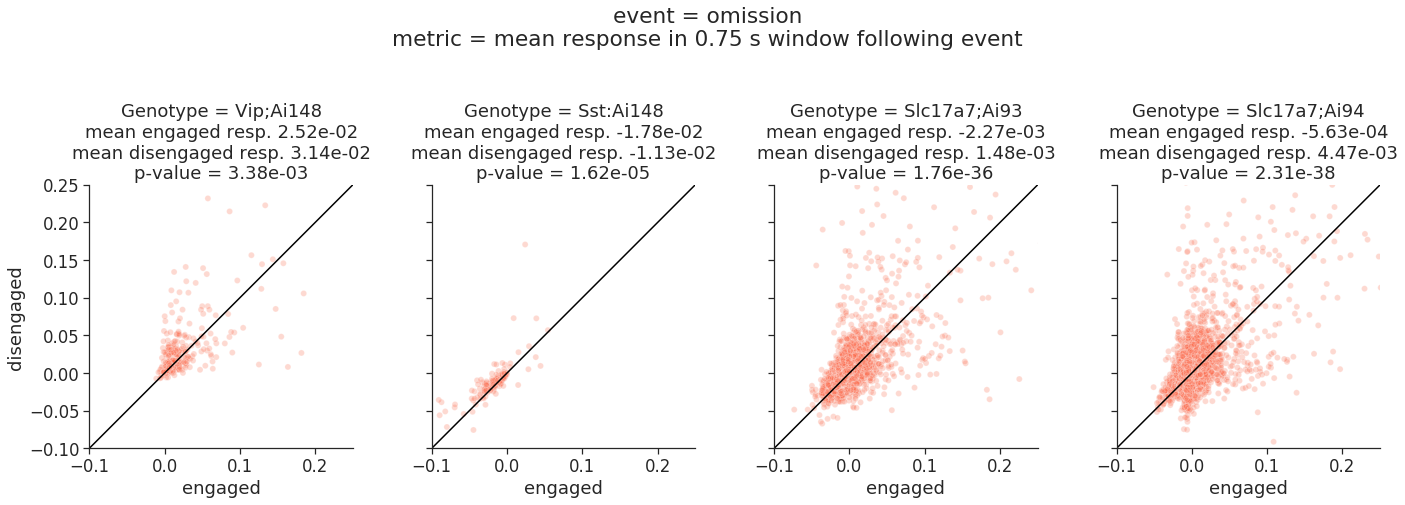

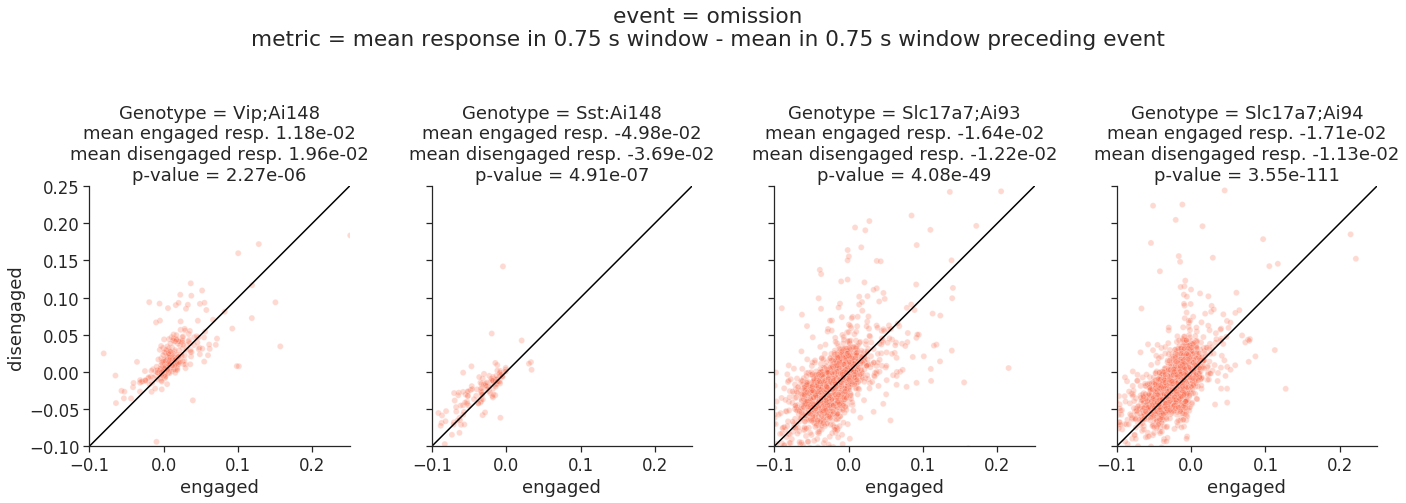

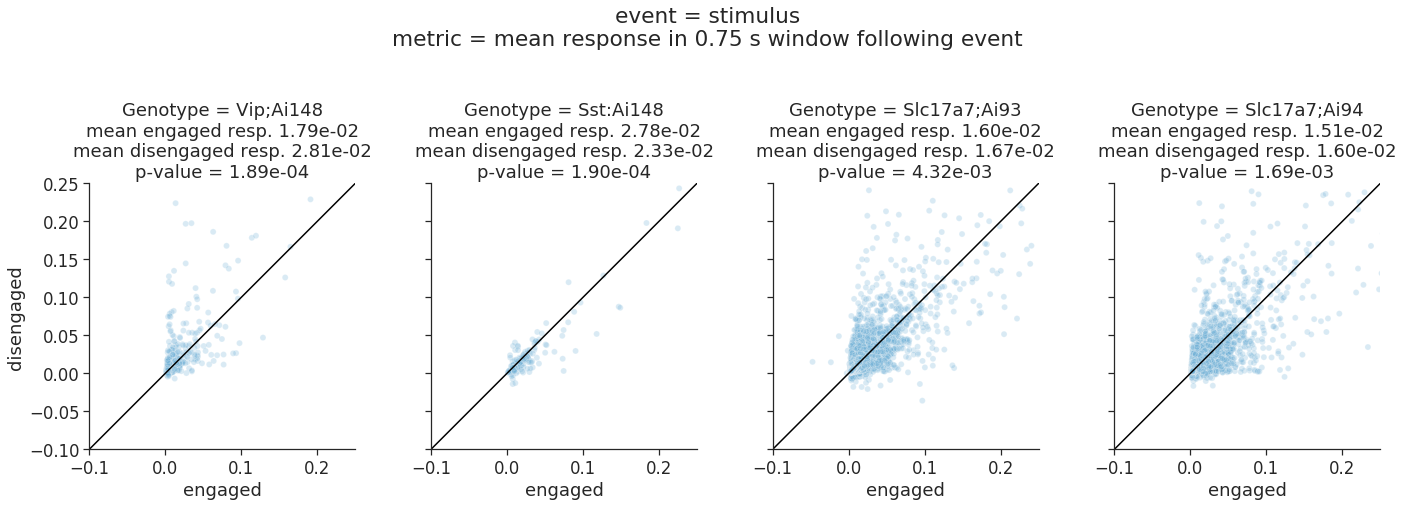

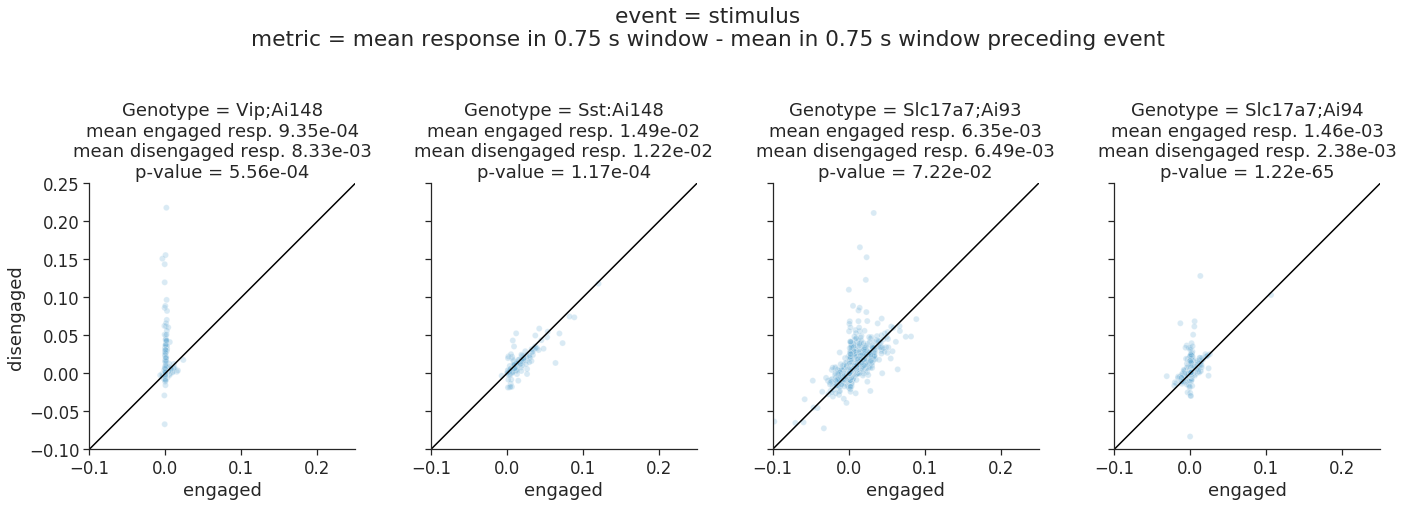

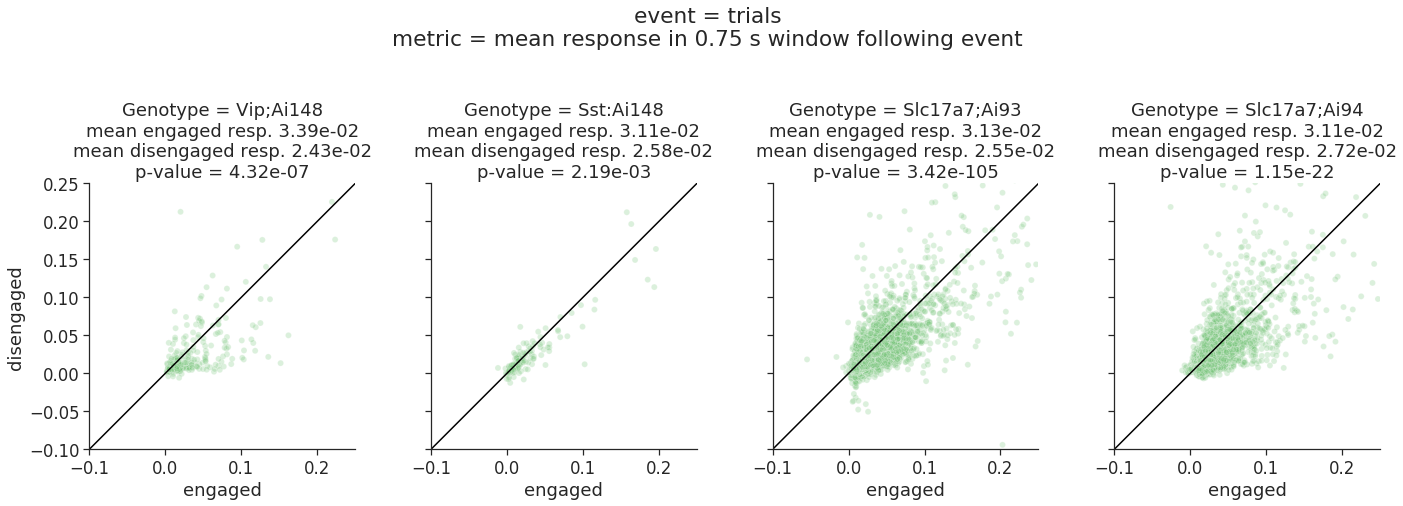

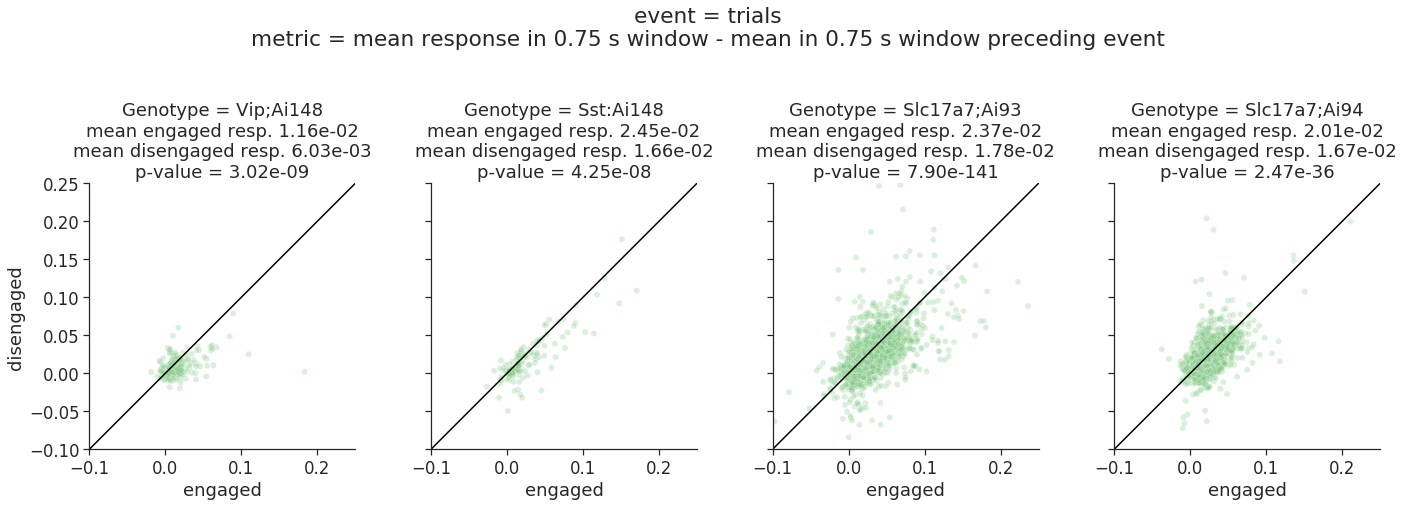

In [238]:
metric_descriptions = {
    'mean_response': 'mean response in 0.75 s window following event',
    'mean_response_magnitude': 'mean response in 0.75 s window - mean in 0.75 s window preceding event',
}
genotype_shorthands = {
    'Vip-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt':'Vip;Ai148',
    'Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt':'Sst:Ai148',
    'Slc17a7-IRES2-Cre/wt;Camk2a-tTA/wt;Ai93(TITL-GCaMP6f)/wt':'Slc17a7;Ai93',
    'Slc17a7-IRES2-Cre/wt;Camk2a-tTA/wt;Ai94(TITL-GCaMP6s)/wt':'Slc17a7;Ai94',
}
colors = {
    'omission':'Reds',
    'trials':'Greens',
    'stimulus':'Blues'
}

for event in['omission','stimulus','trials']:
    for row,metric in enumerate(['mean_response','mean_response_magnitude']):
        fig,ax = plt.subplots(1,4,figsize = (20,8),sharex=True,sharey=True)
        for col,genotype in enumerate(df['full_genotype'].unique()):
            df_pivoted = (
                df.query('full_genotype == @genotype and event_type == @event')
                .pivot_table(values=metric,columns='engagement_state',index=['cell_specimen_id','full_genotype','ophys_experiment_id'])
                .dropna()
                .reset_index()
            )
            df_pivoted = df_pivoted.query('engaged < 1 and disengaged < 1')
            sns.scatterplot(
                data = df_pivoted,
                x = 'engaged',
                y = 'disengaged',
                hue = 'full_genotype',
                legend = False,
                alpha = 0.25,
                palette = colors[event],
                ax = ax[col],
            )
            minval = -0.1
            maxval = 0.25

            ax[col].axis('square')
            ax[col].plot([minval,maxval],[minval,maxval],color='k')
            ax[col].set_xlim(minval,maxval)
            ax[col].set_ylim(minval,maxval)
            p_value = stats.ttest_rel(df_pivoted['engaged'],df_pivoted['disengaged']).pvalue

            ax[col].set_title('Genotype = {}\nmean engaged resp. {:0.2e}\nmean disengaged resp. {:0.2e}\np-value = {:0.2e}'.format(
                genotype_shorthands[genotype], 
                df_pivoted['engaged'].mean(),
                df_pivoted['disengaged'].mean(),
                p_value,
            ))
        fig.tight_layout()
        plt.subplots_adjust(top=0.85)
        fig.suptitle('event = {}\nmetric = {}'.format(event,metric_descriptions[metric]))

In [226]:
df_pivoted = (
    df.query('full_genotype == "Slc17a7-IRES2-Cre/wt;Camk2a-tTA/wt;Ai93(TITL-GCaMP6f)/wt" and event_type == "omission"')
    .pivot_table(values=metric,columns='engagement_state',index=['cell_specimen_id','full_genotype','ophys_experiment_id'])
    .dropna()
    .reset_index()
)
df_pivoted = df_pivoted.query('engaged<1 and disengaged<1')
stats.ttest_rel(df_pivoted['engaged'],df_pivoted['disengaged']).pvalue

4.083937966947208e-49

In [217]:
df_pivoted = (
    df.query('full_genotype == "Slc17a7-IRES2-Cre/wt;Camk2a-tTA/wt;Ai93(TITL-GCaMP6f)/wt" and event_type == "stimulus"')
    .pivot_table(values=metric,columns='engagement_state',index=['cell_specimen_id','full_genotype','ophys_experiment_id'])
    .dropna()
    .reset_index()
)
df_pivoted = df_pivoted.query('engaged<1 and disengaged<1')
stats.ttest_rel(df_pivoted['engaged'],df_pivoted['disengaged']).pvalue

0.07223713178973167

(array([7.136e+03, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00]),
 array([-9.77766335e-02,  3.61812430e+09,  7.23624859e+09,  1.08543729e+10,
         1.44724972e+10,  1.80906215e+10,  2.17087458e+10,  2.53268701e+10,
         2.89449944e+10,  3.25631187e+10,  3.61812430e+10]),
 <a list of 10 Patch objects>)

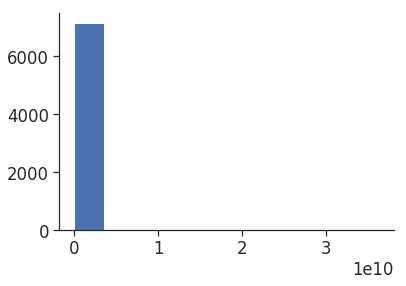

In [216]:
fig,ax=plt.subplots()
ax.hist(df_pivoted['engaged'],)